In [4]:
from keras.models import Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, RandomFlip, RandomRotation, RandomZoom, GaussianNoise, GlobalAveragePooling2D
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import urllib.request
from tensorflow.keras.utils import image_dataset_from_directory
import zipfile
from tensorflow.keras.layers import Resizing, Rescaling
# Install with pip install opencv-python
import cv2

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
print(tf.config.list_physical_devices('GPU'))

[]


Found 250 files belonging to 2 classes.
Using 200 files for training.


Found 250 files belonging to 2 classes.
Using 50 files for validation.
Found 57 files belonging to 2 classes.
class names:  ['Molluscum_contagiosum', 'Warts']
TRAINING


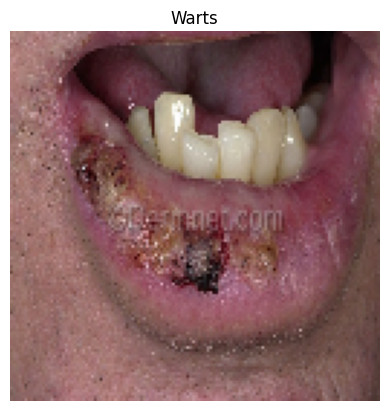

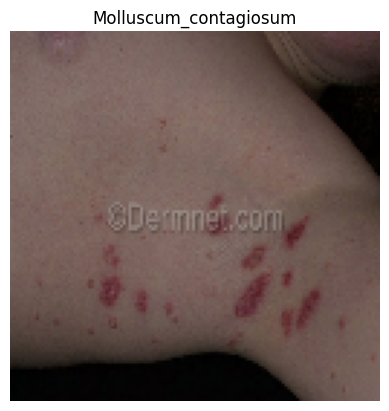

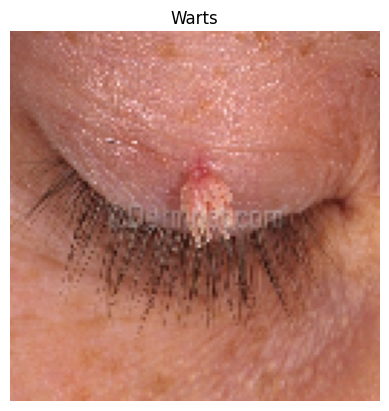

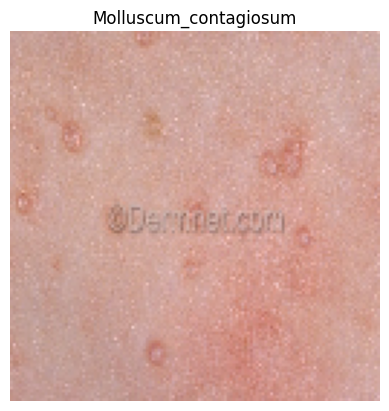

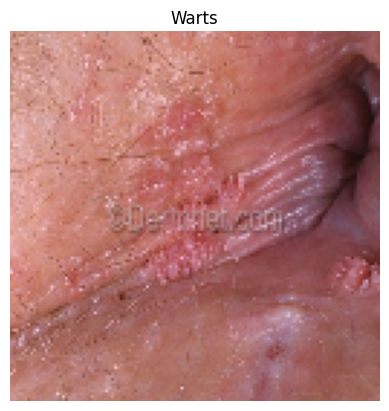




VALIDATION


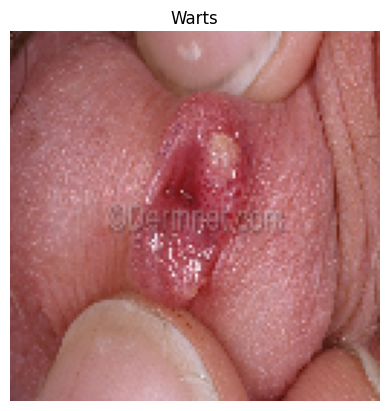

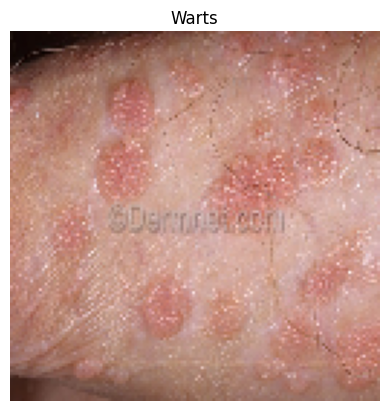




TEST


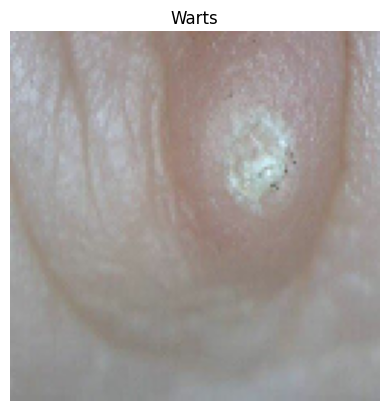

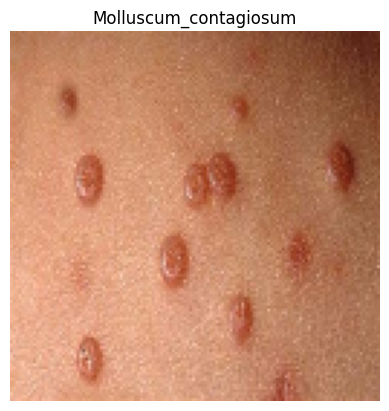

In [6]:
# Take the dataset

training_dir = '../dataset/binary_warts/train'

test_dir = '../dataset/binary_warts/test'

image_size = (128,128)

training_images = image_dataset_from_directory(directory=training_dir, color_mode="rgb", label_mode="binary", batch_size=32, image_size=image_size, shuffle=True, seed=123, validation_split=0.2, subset="training")
validation_images  = image_dataset_from_directory(directory=training_dir, color_mode="rgb", label_mode="binary", batch_size=32, image_size=image_size, shuffle=True, seed=123, validation_split=0.2, subset="validation")
test_images = image_dataset_from_directory(directory=test_dir, color_mode="rgb", label_mode="binary", batch_size=32, image_size=image_size, shuffle=True, seed=123)

class_names = training_images.class_names

print("class names: ", class_names)


print("TRAINING")
 
for images, labels in training_images.take(5):
    plt.imshow(images[0].numpy().astype("uint8"))
    label_idx = int(labels[0].numpy().squeeze())  # from [0.] or [1.] to 0 or 1
    plt.title(class_names[label_idx])
    plt.axis("off")
    plt.show()
print()
print()
print()
print("VALIDATION")

for images, labels in validation_images.take(5):
    plt.imshow(images[0].numpy().astype("uint8"))
    label_idx = int(labels[0].numpy().squeeze())
    plt.title(class_names[label_idx])
    plt.axis("off")
    plt.show()
print()
print()
print()
print("TEST")

for images, labels in test_images.take(5):
    plt.imshow(images[0].numpy().astype("uint8"))
    label_idx = int(labels[0].numpy().squeeze())
    plt.title(class_names[label_idx])
    plt.axis("off")
    plt.show()

# Clean the watermarks (Deprecated)

In [7]:
"""
for images, labels in training_images:
    # Show the original
    plt.imshow(images[0].numpy().astype("uint8"))
    label_idx = int(labels[0].numpy().squeeze())  # from [0.] or [1.] to 0 or 1
    plt.title(class_names[label_idx])
    plt.axis("off")
    plt.show()

    #Clean
    gray = cv2.cvtColor(src=images[0].numpy().astype("uint8"), code=cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, thresh=235, maxval=255, type=cv2.THRESH_BINARY)  # bright logo
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=2)
    result = cv2.inpaint(images[0].numpy().astype("uint8"), mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    cv2.imwrite("clean.jpg", result)

    # Show the clean
    plt.imshow(result.astype("uint8"))
    label_idx = int(labels[0].numpy().squeeze())  # from [0.] or [1.] to 0 or 1
    plt.title(class_names[label_idx])
    plt.axis("off")
    plt.show()
"""



'\nfor images, labels in training_images:\n    # Show the original\n    plt.imshow(images[0].numpy().astype("uint8"))\n    label_idx = int(labels[0].numpy().squeeze())  # from [0.] or [1.] to 0 or 1\n    plt.title(class_names[label_idx])\n    plt.axis("off")\n    plt.show()\n\n    #Clean\n    gray = cv2.cvtColor(src=images[0].numpy().astype("uint8"), code=cv2.COLOR_BGR2GRAY)\n    _, mask = cv2.threshold(gray, thresh=235, maxval=255, type=cv2.THRESH_BINARY)  # bright logo\n    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=2)\n    result = cv2.inpaint(images[0].numpy().astype("uint8"), mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)\n    cv2.imwrite("clean.jpg", result)\n\n    # Show the clean\n    plt.imshow(result.astype("uint8"))\n    label_idx = int(labels[0].numpy().squeeze())  # from [0.] or [1.] to 0 or 1\n    plt.title(class_names[label_idx])\n    plt.axis("off")\n    plt.show()\n'

Clean the watermarks (Better)

In [31]:
# In the terminal
# You will need to install torch and cuda, and obviously iopaint
#  iopaint run --model lama --device cuda --image ./dataset/multi-6/train/Acne --mask ./dataset/mask.jpg --output ./dataset/multi-6_clean/train/Acne_clean 

# Build the model

In [20]:
input_size = (64, 64)

In [21]:
input_shape = image_size + (3,)
print(input_shape)

(128, 128, 3)


In [22]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Freeze for feature extraction

In [23]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    GaussianNoise(0.2)
])

Working toy model

In [ ]:
"""
model = Sequential([

    data_augmentation,

    Resizing(64,64),
    Rescaling(scale=1. / 255, input_shape=(image_size)),

    
    Conv2D(32, kernel_size=(3, 3), padding="same", activation='gelu', input_shape=image_size),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, kernel_size=(3, 3), padding="same", activation='gelu'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, kernel_size=(3, 3), padding="same", activation='gelu'),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),

    Dense(128, activation='gelu'),
    Dense(1, activation='sigmoid')
])
"""

Transfer learning model

In [25]:
model = Sequential([

    data_augmentation,

    Resizing(image_size[0], image_size[1],),
    Rescaling(scale=1. / 255, input_shape=(image_size)),

    base_model,

    GlobalAveragePooling2D(),
    
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # For binary classification
])

c:\Users\Al\Documents\Derma\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
n_epochs = 1000
learn_rate = 0.001
optimizer = Adam(learning_rate=learn_rate)

In [27]:
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [28]:
resumen = model.fit(training_images, epochs=n_epochs, verbose=1, validation_data=validation_images)

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 646ms/step - accuracy: 0.4487 - loss: 0.8134 - val_accuracy: 0.6200 - val_loss: 0.6695
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step - accuracy: 0.6338 - loss: 0.7019 - val_accuracy: 0.6200 - val_loss: 0.6639
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - accuracy: 0.6037 - loss: 0.6874 - val_accuracy: 0.6200 - val_loss: 0.6820
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - accuracy: 0.5749 - loss: 0.7192 - val_accuracy: 0.6200 - val_loss: 0.6841
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - accuracy: 0.5731 - loss: 0.6789 - val_accuracy: 0.6200 - val_loss: 0.6637
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 447ms/step - accuracy: 0.5696 - loss: 0.7301 - val_accuracy: 0.6200 - val_loss: 0.6635
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.5429 - loss: 0.6899 - val_accuracy: 0.6200 - val_loss: 0.6686
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step - accuracy: 0.5210 - loss: 0.7103 - val_accuracy: 0

KeyboardInterrupt: 

In [ ]:
print("History keys:", resumen.history.keys())

# Force an evaluation pass independent of fit
val_results = model.evaluate(validation_images, return_dict=True)
print("Independent val evaluation:", val_results)

History keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7937 - loss: 2.6063
Independent val evaluation: {'accuracy': 0.800000011920929, 'loss': 2.472397804260254}


In [ ]:
print(resumen.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


Text(0.5, 0, 'Epoch')

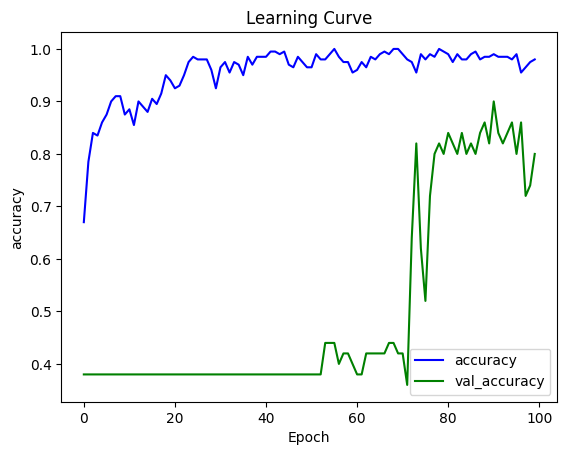

In [ ]:
n_skip = 0 # Eliminamos porque los primeros epochs siempre bajan muy bruscamente en regresión
plt.plot(resumen.history["accuracy"][n_skip:], c="b" )
plt.plot(resumen.history["val_accuracy"][n_skip:], c="g")
plt.title("Learning Curve")
plt.legend(["accuracy", "val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("Epoch")

In [ ]:
eval = model.evaluate(test_images, verbose=0)
print(eval)

[5.190926551818848, 0.5789473652839661]


In [ ]:
print("Test Accuracy: ", (eval[1]))

Test Accuracy:  0.5789473652839661


In [ ]:
predictions = model.predict(test_images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


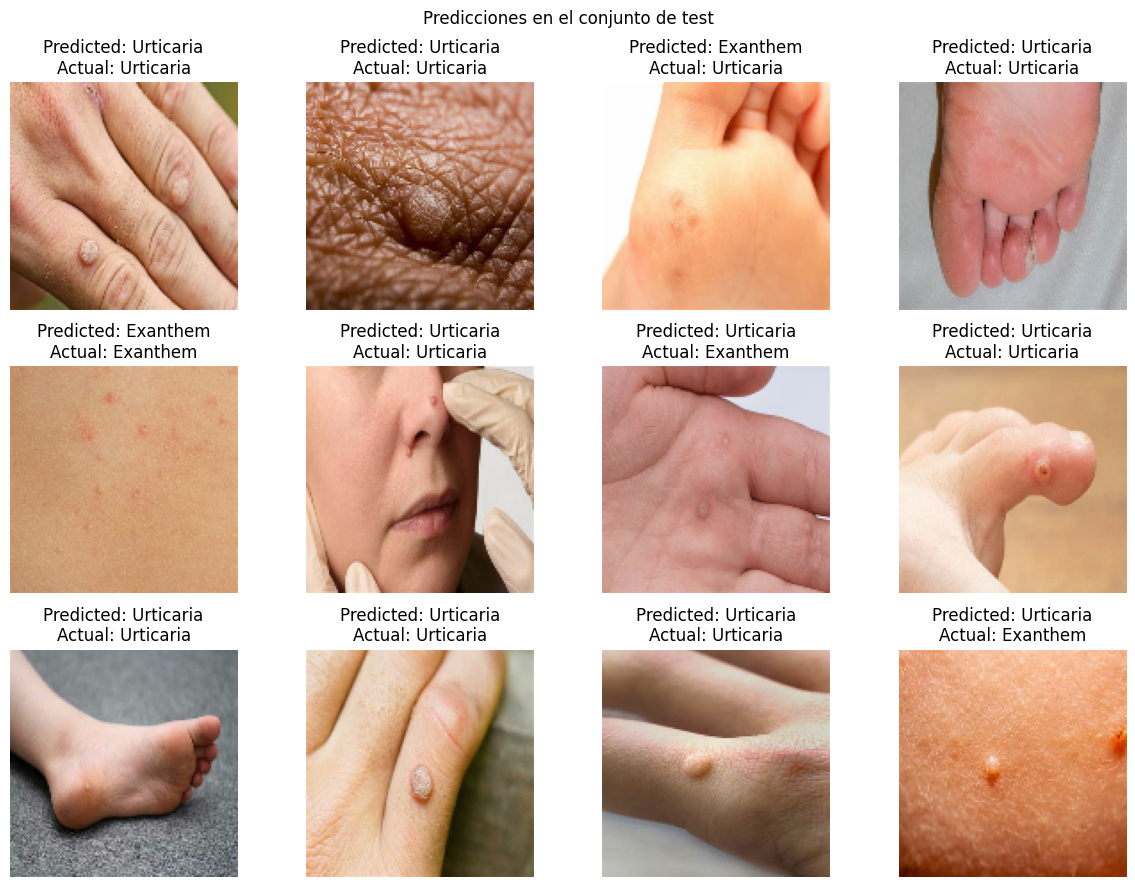

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5735 - loss: 5.4464
Test Loss: 5.1909
Test Accuracy: 0.5789


In [ ]:
for images, labels in test_images.take(1):  # Tomar un batch del conjunto de prueba
    predictions = model.predict(images)  # Asegúrate de predecir este batch

    num_images = min(len(images), 12)
    plt.figure(figsize=(12,9))
    for i in range(num_images):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # No usar .squeeze() ni cmap para imágenes RGB
        predicted_label = "Urticaria" if predictions[i] > 0.5 else "Exanthem"
        actual_label = "Urticaria" if labels[i] == 1 else "Exanthem"
        plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}")
        plt.axis('off')
    plt.suptitle("Predicciones en el conjunto de test")
    plt.tight_layout()
    image = images[i].numpy()
    plt.show()


# Evaluar el modelo sobre el conjunto de test
loss, accuracy = model.evaluate(test_images)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Mirar kaggle
# Finetunning: Congelar convolucionales y crear modulo de clasificación

# Tutorial finetunning / transfer learning

Buscar modelos preentrenados keras Resnet510
Tomar salida de preentrenado, quitar modulo de clasificación y añadir modulo de clasificación

Usar modelo con imagenes médicas

# Agrupar por

Gravedad de las enfermedades

Cost based learning para penalizar

EN la evaluacion, matriz de confusión, 